In [3]:
import MLMarker_app
import pandas as pd
import numpy as np
from MLMarker_app import MLMarker
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [1]:
import matplotlib.pyplot as plt

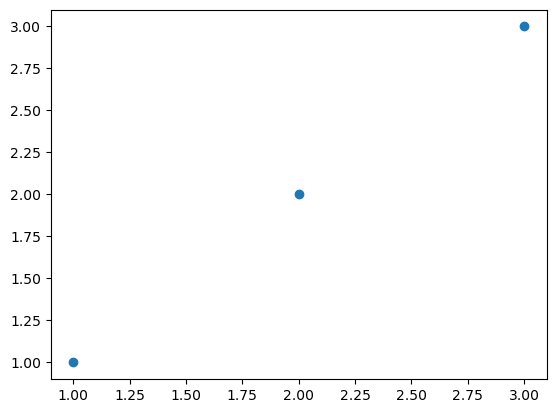

In [2]:
a=[1,2,3]
b=[1,2,3]
plt.scatter(a,b)
plt.show()

Adapt everything to NSAF or binary depending on the model being used!

In [4]:
binary = False
removal= False

test_sample= "/home/compomics/git/MLMarker/data/test_sample.csv"
#get the first row from the 'test sampl'e
test_sample = pd.read_csv(test_sample)
print(test_sample.shape)
test_sample = test_sample.iloc[8:9]

if binary:
    test_sample.iloc[:,5:] = np.where(test_sample.iloc[:,5:] > 0, 1, 0)
    
if removal:
    remove_features = ['Q9UKX5','Q9UKX7','Q9UKY7','Q9UKZ1','Q9UL15','Q9UL25','Q9UL26','Q9UL42','Q9UL54','Q9ULC3','Q9ULC4','Q9ULC5','Q9ULD0','Q9ULD2','Q9ULE0','Q9ULE6','Q9ULH0','Q9ULH7','Q9ULJ3','Q9ULJ7','Q9ULJ8','Q9ULL0','Q9ULL5','Q9ULM3','Q9ULR0','Q9ULR3','Q9ULV0','Q9ULW0','Q9ULX3','Q9ULX6','Q9ULZ3','Q9UM07','Q9UM22','Q9UM47','Q9UMS0','Q9UMS4','Q9UMS6','Q9UMX0','Q9UMX1','Q9UMX3','Q9UMX5','Q9UMZ2','Q9UN37','Q9UN70','Q9UN86','Q9UNF0','Q9UNI6','Q9UNS2','Q9UNW1','Q9UNW9','Q9UNX3','Q9UNX4','Q9UNY4','Q9UNZ2','Q9UP83','Q9UPA5','Q9UPM8','Q9UPN7','Q9UPN9','Q9UPR3','Q9UPU5','Q9UPU7','Q9UPV7','Q9UPY3','Q9UPY6','Q9UPZ3','Q9UQ03','Q9UQ13','Q9UQ35','Q9UQ80','Q9UQE7','Q9UQR1','Q9Y217','Q9Y223','Q9Y224','Q9Y228','Q9Y230','Q9Y237','Q9Y244','Q9Y250','Q9Y259','Q9Y263','Q9Y265','Q9Y266','Q9Y277','Q9Y281','Q9Y294','Q9Y295','Q9Y2A7','Q9Y2C4','Q9Y2D0','Q9Y2D5','Q9Y2G2','Q9Y2H1','Q9Y2H6','Q9Y2I1','Q9Y2I7','Q9Y2J8','Q9Y2K3','Q9Y2L9','Q9Y2P4','Q9Y2P5','Q9Y2Q0','Q9Y2Q3','Q9Y2Q5','Q9Y2R0','Q9Y2R4','Q9Y2S6','Q9Y2S7','Q9Y2T2','Q9Y2T3','Q9Y2U5','Q9Y2U8','Q9Y2V2','Q9Y2V7','Q9Y2W2','Q9Y2X3','Q9Y2X9','Q9Y2Y8','Q9Y2Z0','Q9Y2Z4','Q9Y305','Q9Y316','Q9Y320','Q9Y333','Q9Y366','Q9Y376','Q9Y385','Q9Y394','Q9Y399','Q9Y3A2','Q9Y3A4','Q9Y3A6','Q9Y3B4','Q9Y3B7','Q9Y3B9','Q9Y3C4','Q9Y3C6','Q9Y3C8','Q9Y3D0','Q9Y3D2','Q9Y3D5','Q9Y3D6','Q9Y3D9','Q9Y3E1','Q9Y3E2','Q9Y3E7','Q9Y3F4','Q9Y3I0','Q9Y3I1','Q9Y3L3','Q9Y3P9','Q9Y3Q3','Q9Y3Q8','Q9Y3R5','Q9Y3T9','Q9Y3U8','Q9Y3Z3','Q9Y426','Q9Y446','Q9Y478','Q9Y490','Q9Y4B5','Q9Y4B6','Q9Y4C1','Q9Y4C2','Q9Y4C8','Q9Y4D1','Q9Y4D7','Q9Y4E6','Q9Y4E8','Q9Y4G6','Q9Y4H2','Q9Y4J8','Q9Y4K3','Q9Y4K4','Q9Y4P1','Q9Y4P8','Q9Y4W2','Q9Y4W6','Q9Y4X5','Q9Y4Y9','Q9Y512','Q9Y570','Q9Y572','Q9Y584','Q9Y5A9','Q9Y5B6','Q9Y5B9','Q9Y5J1','Q9Y5J6','Q9Y5J7','Q9Y5K6','Q9Y5L3','Q9Y5L4','Q9Y5M8','Q9Y5N5','Q9Y5P6','Q9Y5R8','Q9Y5S1','Q9Y5S2','Q9Y5S9','Q9Y5T5','Q9Y5U8','Q9Y5V3','Q9Y5X1','Q9Y5X2','Q9Y5X3','Q9Y5Y6','Q9Y5Y7','Q9Y5Z4','Q9Y5Z7','Q9Y608','Q9Y613','Q9Y617','Q9Y619','Q9Y623','Q9Y624','Q9Y625','Q9Y646','Q9Y657','Q9Y673','Q9Y676','Q9Y678','Q9Y679','Q9Y680','Q9Y692','Q9Y696','Q9Y697','Q9Y6A4','Q9Y6C2','Q9Y6C9','Q9Y6D5','Q9Y6D6','Q9Y6D9','Q9Y6G9','Q9Y6H1','Q9Y6I3','Q9Y6K5','Q9Y6M5','Q9Y6N5','Q9Y6N6','Q9Y6P5','Q9Y6Q1','Q9Y6Q9','Q9Y6R1','Q9Y6U3','Q9Y6V0','Q9Y6V7','Q9Y6W3','Q9Y6W5','Q9Y6X5','Q9Y6X8','Q9Y6X9','Q9Y6Y0','Q9Y6Y8']
    test_sample = test_sample.drop(columns=remove_features)

test_sample

test = MLMarker(test_sample, binary = False)

(13, 11897)


Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [5]:
x = MLMarker.calculate_shap(test)
x.shape

(35, 4384)

In [6]:
test_sample

,index,assay_id,cell_type,tissue_name,disease_status,fluid,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,...,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8
8,7434,9873,Urine,Urine,Diseased,1,0.0,0.012536,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
x = MLMarker.predict_top_tissues(test)
x

[('Prostate', 0.1316),
 ('Kidney', 0.1243),
 ('Esophagus', 0.0772),
 ('Salivary gland', 0.0607),
 ('Brain', 0.0409)]

In [8]:
MLMarker.interpret_shap_values(test, n_preds=3)

,A0A075B6H7,A0A075B6I0,A0A075B6Q5,A0A0A0MS14,A0A0A0MS15,A0A0B4J1U7,A0A0B4J1V0,A0A0B4J1V6,A0A0B4J1X8,A0A0B4J2F0,...,Q9Y6U3,Q9Y6V0,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
tissue,,,,,,,,,,,,,,,,,,,,,
Prostate,0.000000,-0.000792,0.0,-0.000004,0.000000,0.000002,-0.000004,0.0,0.0,0.0,...,0.000026,0.000058,0.0,0.0,3.601020e-07,5.599108e-07,1.463637e-07,0.0,0.0,8.775597e-07
Kidney,-0.000026,-0.000329,0.0,0.000000,-0.000007,-0.000004,-0.000005,0.0,0.0,0.0,...,0.000138,0.000051,0.0,0.0,1.108837e-04,0.000000e+00,1.842645e-06,0.0,0.0,3.656499e-07
Esophagus,0.000000,0.000006,0.0,0.000004,-0.000003,-0.000003,0.000044,0.0,0.0,0.0,...,-0.000004,0.000068,0.0,0.0,0.000000e+00,0.000000e+00,3.509504e-06,0.0,0.0,4.113561e-07


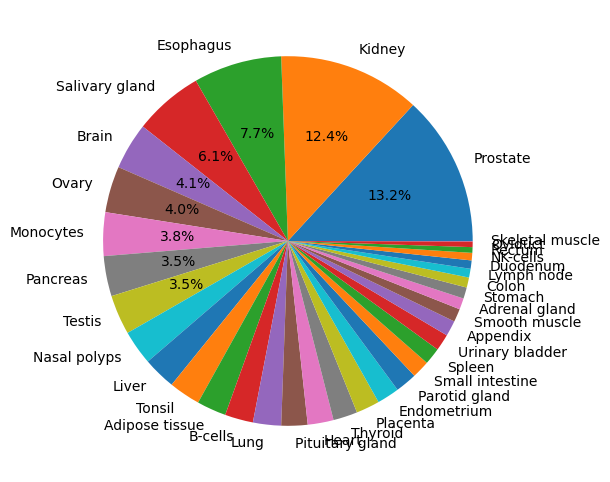

In [10]:
MLMarker.pie_chart_predictions(test)

4384 4384


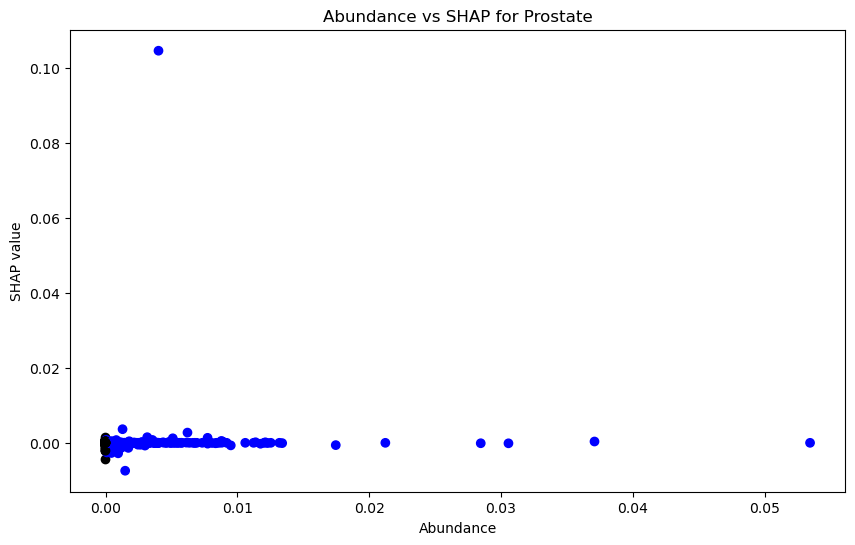

4384 4384


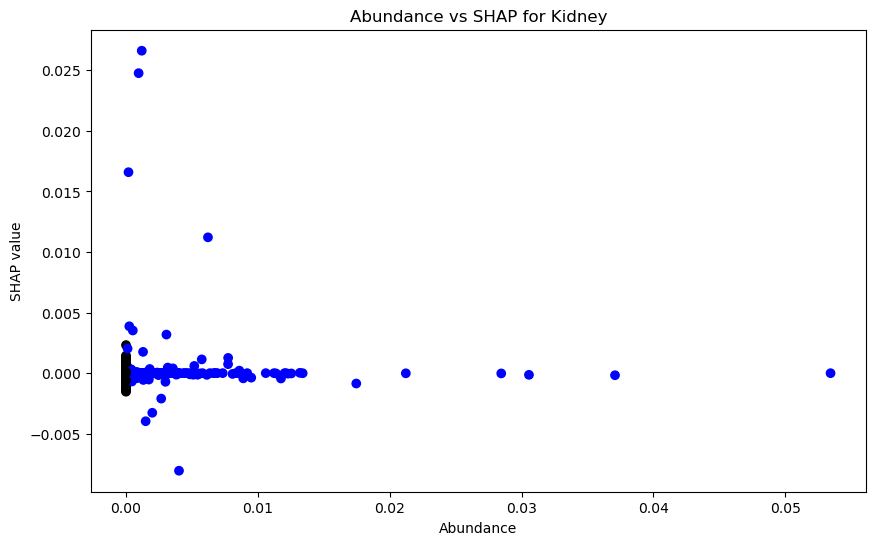

4384 4384


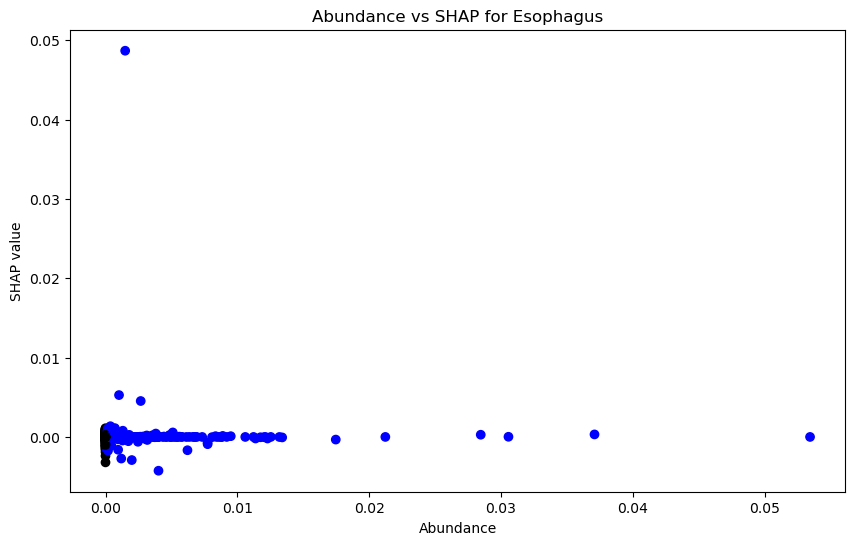

In [12]:
MLMarker.shap_abundance_distribution(test, n_preds=3)

The base value is 0.028571428571428373
Prostate


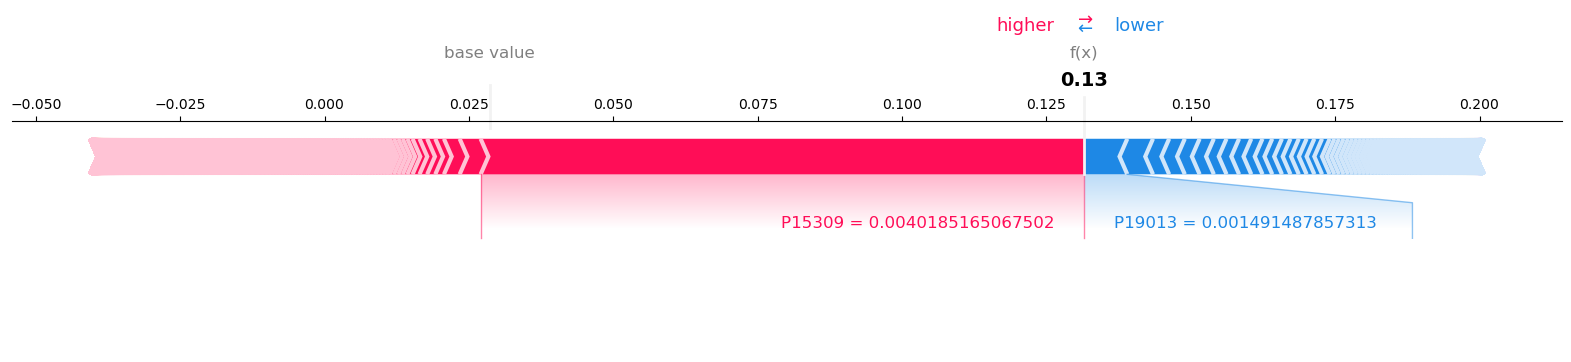

None

Kidney


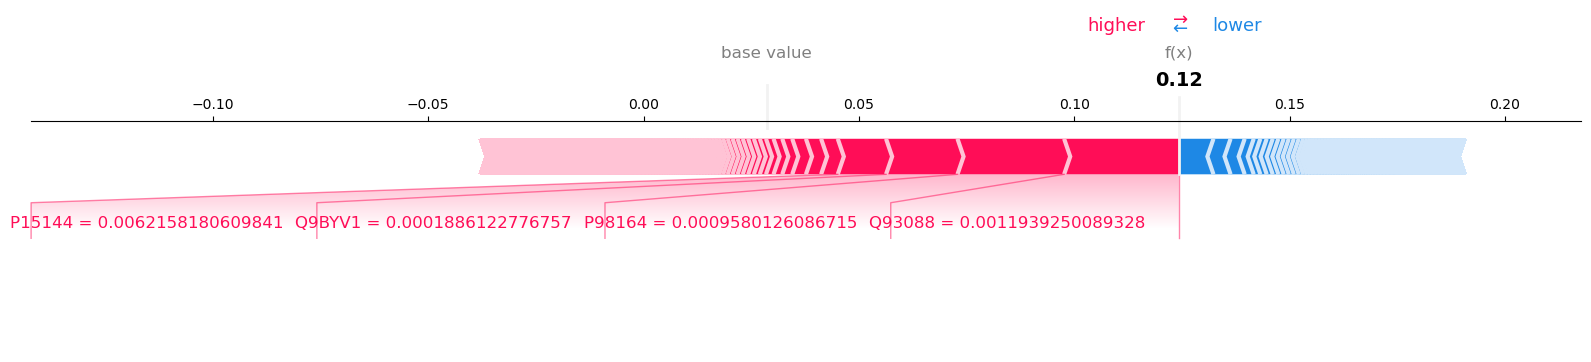

None

Esophagus


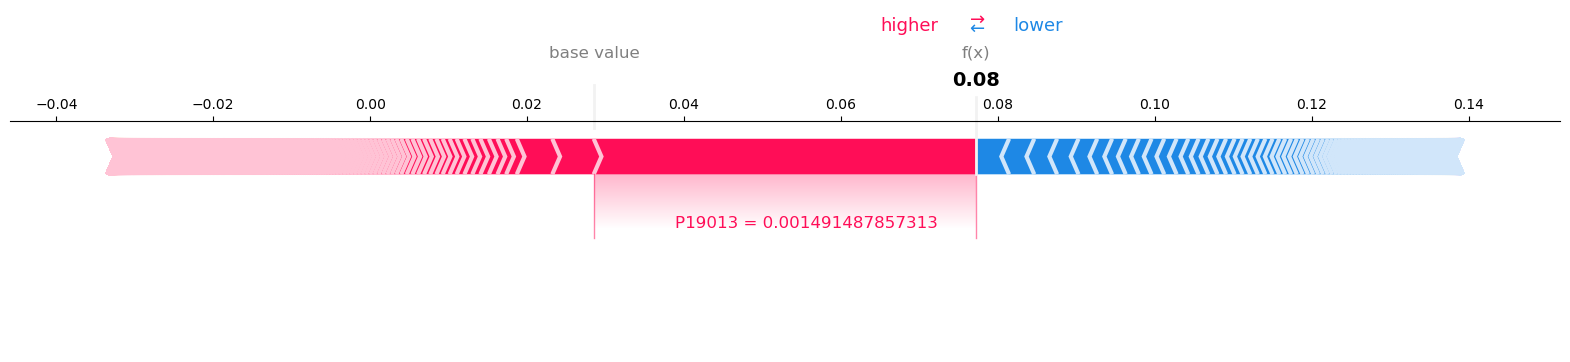

None

In [13]:
MLMarker.visualize_shap_force_plot(test, n_preds=3) 